In [80]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import re
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay

In [81]:

CHARTEVENTS_BY_ICUSTAY_ID = 'data/parquet/'
REDUCED_CE_BY_ICUSTAY_ID = 'data/samples/'
NUMERICAL_BY_ICUSTAY_ID = 'data/samples_numerical/'
STATB_BY_ICUSTAY_ID = 'data/samples_statB/'
DEMO_BY_ICUSTAY_ID = 'data/samples_demographics/'
ICD9_BY_ICUSTAY_ID = 'data/samples_icd9/'
CHARTEVENTS_FILENAME = 'mimic-iii/CHARTEVENTS.csv'
DIAGNOSES_FILENAME = 'mimic-iii/DIAGNOSES_ICD.csv'
READMISSION_FILENAME = 'data/readmission.csv'
EMBEDDED_FILENAME = 'resources/embedded.parquet'
ANNOTATION_FILENAME = 'data/anotation.csv'
STEP_FAIL_FILE = 'Step9_failed.txt'
BASELINE_FILENAME = 'data/baseline_data.csv'


In [82]:
K_FOLDS = 5
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.5
RANDOM_STATE = 1234
EPOCH = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
MAX_DEPTH = 2

In [83]:
baseline_data = pd.read_csv(BASELINE_FILENAME).fillna(0.0)
baseline_data.head(2)

,READMISSION,0,1,2,3,4,5,6,7,8,...,323,324,325,326,327,328,329,330,331,332
0,0,4.000000,6.0,5.000000,15.000000,1.0,-0.170751,58.956522,1.107123,60.350601,...,-0.320951,1.725547,-4.059063,2.593838,-1.155438,-0.484720,0,0,0,61
1,0,3.714286,6.0,3.571429,13.285714,0.0,-0.264872,70.891156,-0.329190,89.048469,...,-0.278201,-0.392379,-0.189603,1.040975,0.621470,0.266834,1,3,1,48


In [84]:
baseline_data.dtypes

READMISSION      int64
0              float64
1              float64
2              float64
3              float64
                ...   
328            float64
329              int64
330              int64
331              int64
332              int64
Length: 334, dtype: object

In [85]:
train_dataset, remaining = train_test_split(baseline_data, train_size=TRAIN_SPLIT, random_state=RANDOM_STATE,shuffle=False)
valid_dataset, test_dataset = train_test_split(remaining, test_size=TEST_SPLIT, random_state=RANDOM_STATE,shuffle=False)

In [86]:
train_x = train_dataset.iloc[:,1:]
train_y = train_dataset.iloc[:,0]

valid_x = valid_dataset.iloc[:,1:]
valid_y = valid_dataset.iloc[:,0]

test_x = test_dataset.iloc[:,1:]
test_y = test_dataset.iloc[:,0]

## Random Forest

In [87]:
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)

In [88]:
rf_clf.fit(train_x,train_y)

RandomForestClassifier(oob_score=True, random_state=1234)

In [89]:
train_predict = rf_clf.predict(train_x)
valid_predict = rf_clf.predict(valid_x)
test_predict = rf_clf.predict(test_x)

In [90]:
def getMetrics(y_actual, y_predict):
    
    precision = metrics.precision_score(y_actual,y_predict)
    accuracy = metrics.accuracy_score(y_actual,y_predict)
    recall = metrics.recall_score(y_actual,y_predict)

    return precision, accuracy, recall

In [91]:


print('Training     \tPrecision: {:.4f} \tAccuracy: {:.4f} \tRecall: {:.4f}'.format(*getMetrics(train_y,train_predict) ))
print('Validation   \tPrecision: {:.4f} \tAccuracy: {:.4f} \tRecall: {:.4f}'.format(*getMetrics(valid_y,valid_predict) ))
print('Testing      \tPrecision: {:.4f} \tAccuracy: {:.4f} \tRecall: {:.4f}'.format(*getMetrics(test_y,test_predict) ))

Training     	Precision: 1.0000 	Accuracy: 1.0000 	Recall: 0.9999
Validation   	Precision: 0.4645 	Accuracy: 0.8031 	Recall: 0.1993
Testing      	Precision: 0.4548 	Accuracy: 0.8100 	Recall: 0.1945


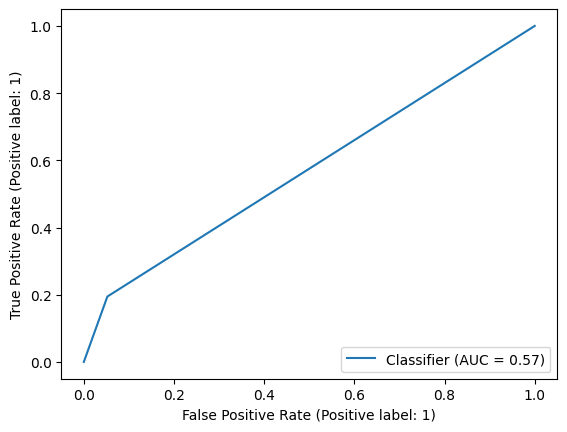

In [92]:
RocCurveDisplay.from_predictions(test_y, test_predict)
plt.show()

## Support Vector Machine

In [97]:
clf = SVC(random_state=RANDOM_STATE)

In [98]:
clf.fit(train_x,train_y)

SVC(random_state=1234)

In [99]:
train_predict = clf.predict(train_x)
valid_predict = clf.predict(valid_x)
test_predict = clf.predict(test_x)

In [100]:
print('Training     \tPrecision: {:.4f} \tAccuracy: {:.4f} \tRecall: {:.4f}'.format(*getMetrics(train_y,train_predict) ))
print('Validation   \tPrecision: {:.4f} \tAccuracy: {:.4f} \tRecall: {:.4f}'.format(*getMetrics(valid_y,valid_predict) ))
print('Testing      \tPrecision: {:.4f} \tAccuracy: {:.4f} \tRecall: {:.4f}'.format(*getMetrics(test_y,test_predict) ))

Training     	Precision: 1.0000 	Accuracy: 0.8059 	Recall: 0.0005
Validation   	Precision: 0.0000 	Accuracy: 0.8089 	Recall: 0.0000
Testing      	Precision: 0.0000 	Accuracy: 0.8171 	Recall: 0.0000


/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/Bencsik/SSD1/CS 598 Project/CS598CourseProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


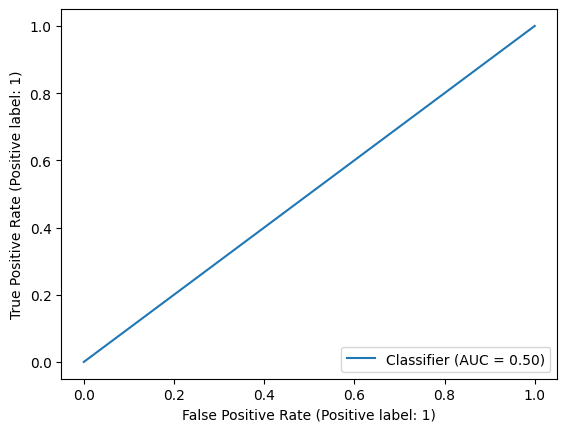

In [101]:
RocCurveDisplay.from_predictions(test_y, test_predict)
plt.show()